In [2]:
# ============================================
# 04_evaluation.ipynb — Feature Analysis & SHAP
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import shap

os.makedirs("../results/feature_importance", exist_ok=True)
os.makedirs("../results/metrics", exist_ok=True)

print("📌 Loading models and data...")

📌 Loading models and data...


In [3]:
# ============================================
# 1. Load preprocessed dataset
# ============================================

X_train = np.load("../data/processed/X_train.npy", allow_pickle=True)
X_test = np.load("../data/processed/X_test.npy", allow_pickle=True)
y_train = np.load("../data/processed/y_train.npy", allow_pickle=True)
y_test = np.load("../data/processed/y_test.npy", allow_pickle=True)

preprocessor = joblib.load("../models/preprocessor.pkl")

print(X_train.shape, X_test.shape)

(35994, 27) (8999, 27)


In [4]:
# ============================================
# 2. Load trained models
# ============================================

log_reg = joblib.load("../models/logistic_regression.pkl")
rf = joblib.load("../models/random_forest.pkl")
xgb = joblib.load("../models/xgboost.pkl")

models = {
    "logistic_regression": log_reg,
    "random_forest": rf,
    "xgboost": xgb
}

models

{'logistic_regression': LogisticRegression(max_iter=500),
 'random_forest': RandomForestClassifier(n_estimators=150),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, ...)}


===== LOGISTIC_REGRESSION =====
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7002
           1       0.78      0.75      0.77      1997

    accuracy                           0.90      8999
   macro avg       0.86      0.85      0.85      8999
weighted avg       0.90      0.90      0.90      8999



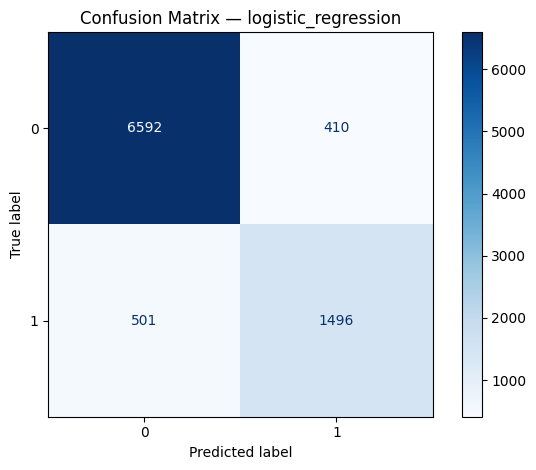


===== RANDOM_FOREST =====
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7002
           1       0.90      0.77      0.83      1997

    accuracy                           0.93      8999
   macro avg       0.92      0.87      0.89      8999
weighted avg       0.93      0.93      0.93      8999



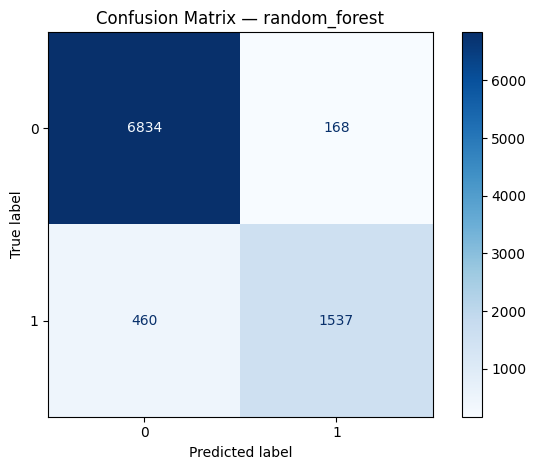


===== XGBOOST =====
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7002
           1       0.90      0.80      0.84      1997

    accuracy                           0.93      8999
   macro avg       0.92      0.88      0.90      8999
weighted avg       0.93      0.93      0.93      8999



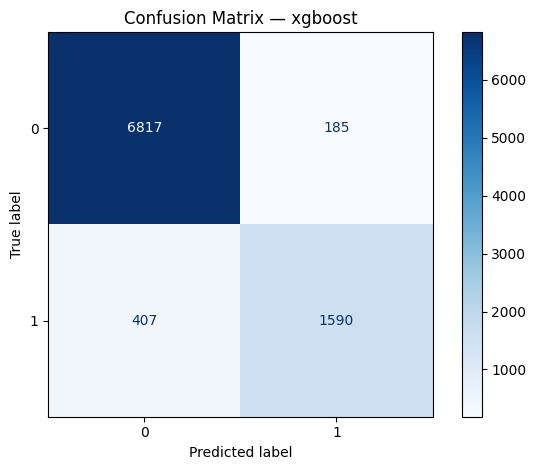

Confusion matrices saved.


In [5]:
# ============================================
# 3. Classification Report & Confusion Matrix
# ============================================

for name, model in models.items():
    print(f"\n===== {name.upper()} =====")
    preds = model.predict(X_test)

    # Classification Report
    print(classification_report(y_test, preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.savefig(f"../results/metrics/confusion_matrix_{name}.png")
    plt.show()

print("Confusion matrices saved.")

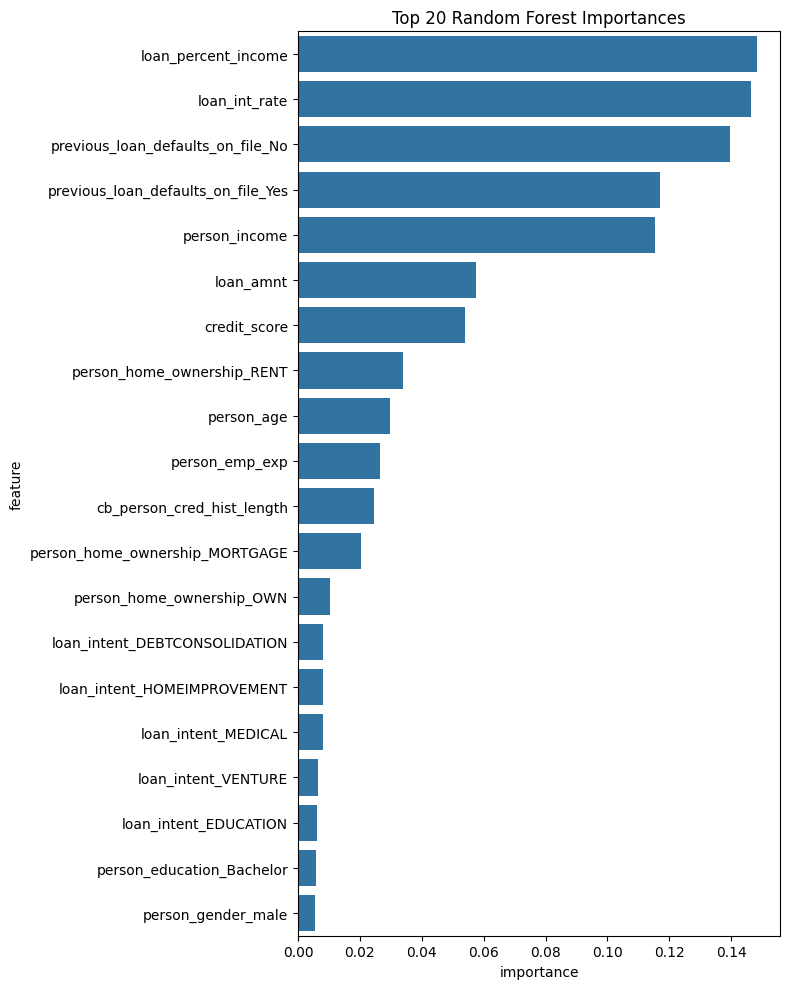

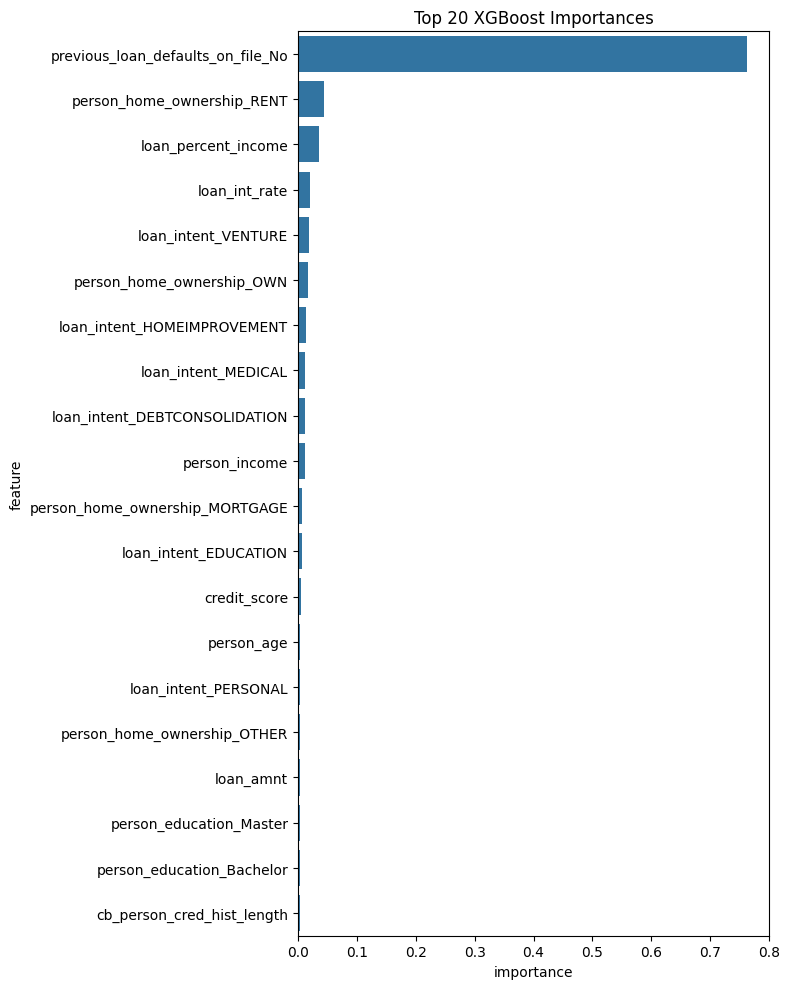

Feature importance saved!


In [6]:
# ============================================
# 4. Feature Importance (RF & XGB)
# ============================================

# Extract transformed feature names
cat_cols = preprocessor.transformers_[1][2]
num_cols = preprocessor.transformers_[0][2]

ohe = preprocessor.transformers_[1][1]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = list(num_cols) + list(cat_feature_names)

# Random Forest
rf_importances = rf.feature_importances_

df_rf = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
}).sort_values(by="importance", ascending=False)

df_rf.to_csv("../results/feature_importance/random_forest_importance.csv", index=False)

plt.figure(figsize=(8,10))
sns.barplot(data=df_rf.head(20), x="importance", y="feature")
plt.title("Top 20 Random Forest Importances")
plt.tight_layout()
plt.savefig("../results/feature_importance/random_forest_importance.png")
plt.show()

# XGBoost
xgb_importances = xgb.feature_importances_

df_xgb = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_importances
}).sort_values(by="importance", ascending=False)

df_xgb.to_csv("../results/feature_importance/xgboost_importance.csv", index=False)

plt.figure(figsize=(8,10))
sns.barplot(data=df_xgb.head(20), x="importance", y="feature")
plt.title("Top 20 XGBoost Importances")
plt.tight_layout()
plt.savefig("../results/feature_importance/xgboost_importance.png")
plt.show()

print("Feature importance saved!")

📌 Running SHAP analysis (XGBoost)...


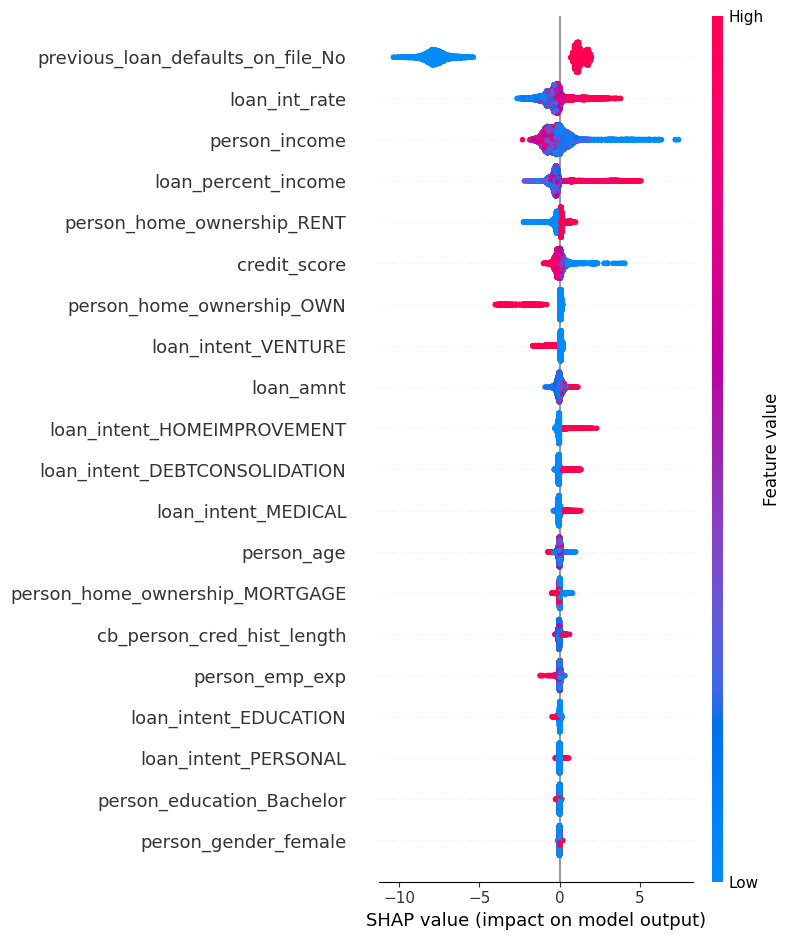

SHAP summary saved to shap_summary.png


In [7]:
# ============================================
# 5. SHAP Analysis (XGBoost recommended)
# ============================================

print("📌 Running SHAP analysis (XGBoost)...")

explainer = shap.TreeExplainer(xgb)
shap_values = explainer(X_test)

np.save("../results/feature_importance/shap_values.npy", shap_values.values)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values.values, X_test, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig("../results/feature_importance/shap_summary.png", dpi=200)
plt.show()

print("SHAP summary saved to shap_summary.png")